In [11]:
%matplotlib widget

import math
import csv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import antropy as ant
from sklearn.preprocessing import StandardScaler

In [12]:
begin, end = 1, 61 # (begin is inclusive, end is exclusive)
num_people = 10
count_samples = {
    "active": 8,
    "meditate": 8,
    "neutral": 8
}

class Sample:
    def __init__(self):
        self.data = {
            'RawEEG': [],
            'Alpha': [],
            'Low Beta': [],
            'High Beta': [],
            'Gamma': [],
            'Theta': [],
            'Delta': [],
            'Meditation': [],
            'Attention': []
        }

    def recordDataPoint(self, RawEEG, Attention, Meditation, Alpha, Delta, Theta, LowBeta, HighBeta, Gamma):
        self.data['RawEEG'].append(float(RawEEG))
        self.data['Attention'].append(float(Attention))
        self.data['Meditation'].append(float(Meditation))
        self.data['Alpha'].append(float(Alpha))
        self.data['Delta'].append(float(Delta))
        self.data['Theta'].append(float(Theta))
        self.data['Low Beta'].append(float(LowBeta))
        self.data['High Beta'].append(float(HighBeta))
        self.data['Gamma'].append(float(Gamma))

    '''
    Record a line of data from the CSV output, which takes form RawEEG, Alpha, Delta, Gamma, Low Beta, High Beta, Theta, Attention, Meditation

    '''
    def recordDataLine(self, line):
        self.recordDataPoint(line[0], line[7], line[8], line[1], line[2], line[6], line[4], line[5], line[3])
    
    def getEEG(self):
        return self.data['RawEEG']
    
    def getAttention(self):
        return self.data["Attention"]
    
    def getMeditation(self):
        return self.data["Meditation"]
    
    def getAlpha(self):
        return self.data["Alpha"]
    
    def getDelta(self):
        return self.data["Delta"]
    
    def getTheta(self):
        return self.data["Theta"]
    
    def getLowBeta(self):
        return self.data["Low Beta"]
    
    def getHighBeta(self):
        return self.data["High Beta"]
    
    def getGamma(self):
        return self.data["Gamma"]

    def get(self, key):
        return self.data[key]

In [13]:
data = []
dataLabels = []

def transcribeFileToSample(personN: int, sampleN: int, state: str):
    sample_data = Sample()

    with open("data/all_data/" + state + "_" + str(personN) + "_" + str(sampleN) + ".csv") as f:
        reader = csv.reader(f)

        header = next(reader)
        
        for row in reader:
            sample_data.recordDataLine(row)

        for key in sample_data.data:
            sample_data.data[key] = sample_data.data[key][begin:end]

        data.append(sample_data)
        dataLabels.append(state)

for person in range(num_people):
    for state in count_samples:
        for i in range(count_samples[state]):
            transcribeFileToSample(person + 1, i + 1, state)

In [14]:
dataExtracted = []

def safety_check(x):
    if math.isnan(x): return 0
    if math.isinf(x): return 99999999999
    return x

for point in data:
    extractedPoint = []

    for key in ['RawEEG', 'Alpha', 'Delta', 'Theta', 'Low Beta', 'High Beta', 'Gamma']:
        for func in [np.mean, np.std, ant.sample_entropy, ant.petrosian_fd]:
            extractedPoint.append(safety_check(func(point.get(key))))

    extractedPoint.append(safety_check(ant.spectral_entropy(point.getEEG(), sf=1)))
    
    dataExtracted.append(extractedPoint)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/antropy/entropy.py:249: RuntimeWarning: divide by zero encountered in log2
  se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/antropy/entropy.py:249: RuntimeWarning: invalid value encountered in multiply
  se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)


In [24]:
x = dataExtracted
y = dataLabels

n_PCA_comps = 20

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

pca = PCA(n_components = n_PCA_comps)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

forestclassifier = RandomForestClassifier(n_estimators=800)
forestclassifier.fit(x_train, y_train)

RandomForestClassifier(n_estimators=800)

In [25]:
for name, importance in sorted(zip([f"PCA {n+1}" for n in range(n_PCA_comps)], forestclassifier.feature_importances_), key=lambda x: x[1], reverse=True):
    print(name, importance)

PCA 1 0.07905328215108015
PCA 3 0.06976082021687861
PCA 4 0.06941523793823036
PCA 19 0.06314733379212245
PCA 9 0.05201534568738629
PCA 14 0.05133479106906077
PCA 15 0.05022865177558586
PCA 13 0.04902875132786321
PCA 20 0.047262244948970945
PCA 18 0.046613475276968054
PCA 5 0.04583093101927677
PCA 8 0.044779767401290145
PCA 7 0.04464124069709596
PCA 17 0.04361655028388035
PCA 12 0.04360974264879256
PCA 6 0.04220881728815176
PCA 2 0.04132359039227828
PCA 10 0.03901673932559906
PCA 16 0.03878416872417606
PCA 11 0.03832851803531239


In [26]:
transformed_all_data = pca.transform(sc.transform(dataExtracted))

principalDf = pd.DataFrame(data = transformed_all_data, columns = ['PCA' + str(i+1) for i in range(n_PCA_comps)])
labelsDf = pd.DataFrame(data = dataLabels, columns = ['target'])

df = pd.concat((principalDf, labelsDf), axis = 1)

for col in ['PCA' + str(i+1) for i in range(n_PCA_comps)]:
    df[col] = df[col].astype(float)
    df = df[np.abs(df[col]) < 10]

In [27]:
print(classification_report(y_test, forestclassifier.predict(x_test)))
print(forestclassifier.score(x_test, y_test))

              precision    recall  f1-score   support

      active       0.62      0.26      0.37        19
    meditate       0.45      0.69      0.55        13
     neutral       0.50      0.62      0.56        16

    accuracy                           0.50        48
   macro avg       0.53      0.53      0.49        48
weighted avg       0.54      0.50      0.48        48

0.5


0.9980467861331141


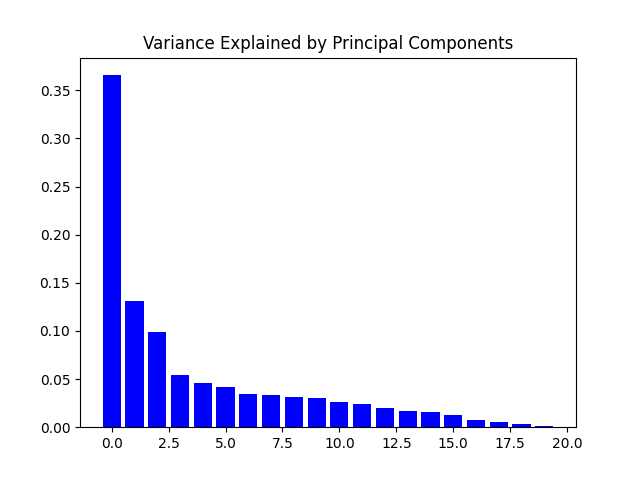

In [28]:
plt.figure()
plt.title("Variance Explained by Principal Components")
plt.bar(range(n_PCA_comps), pca.explained_variance_ratio_, color = 'blue')
print(sum(pca.explained_variance_ratio_))

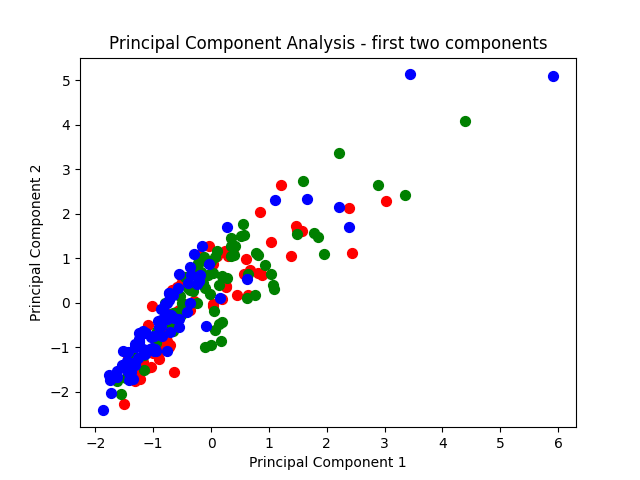

In [20]:
fig = plt.figure()
plt.title("Principal Component Analysis - first two components")
targets = ['active', 'neutral', 'meditate']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['target'] == target
    plt.scatter(df.loc[indicesToKeep, 'PCA1']
               , df.loc[indicesToKeep, 'PCA2']
               , c = color
               , s = 50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

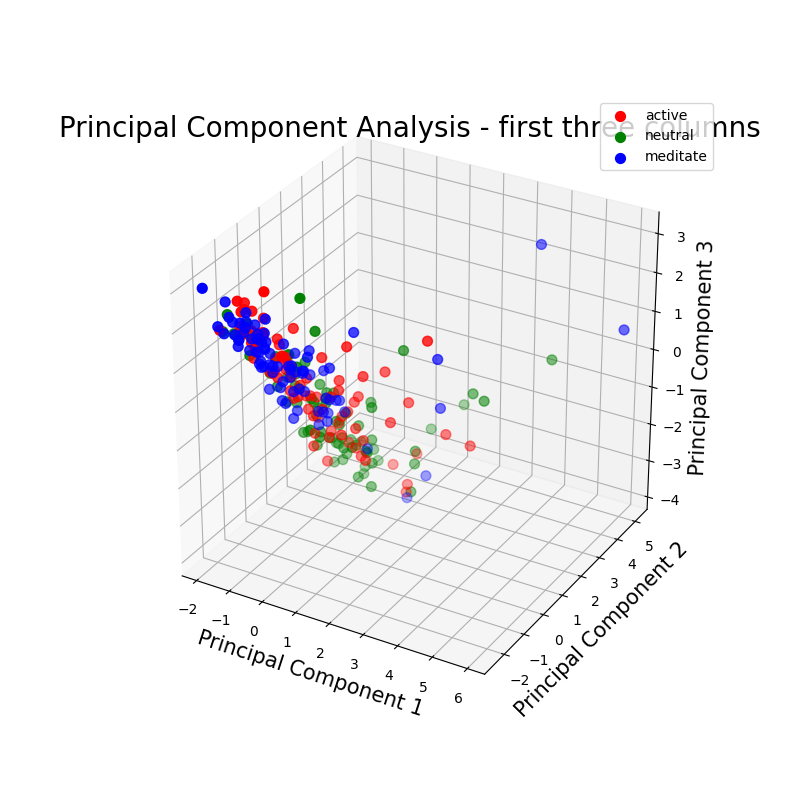

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('Principal Component Analysis - first three columns', fontsize = 20)
targets = ['active', 'neutral', 'meditate']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['target'] == target
    ax.scatter(df.loc[indicesToKeep, 'PCA1']
               , df.loc[indicesToKeep, 'PCA2']
               , df.loc[indicesToKeep, 'PCA3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()